In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Embedding, concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, SpatialDropout1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

%run pretprocesiranje.ipynb
%run model.ipynb
%run evaluacija.ipynb

df1 = pd.read_csv("trening.csv")
df1.rename(columns={ '0':'tekst', '1':'pisac'}, 
                 inplace=True)

#funkcija sample sluzi za nasumicno mesanje samplova  
#df1 = df1.sample(frac=1)
df1.size
df1.reset_index(drop=True, inplace=True)

Using TensorFlow backend.


In [2]:
#tf.random.set_seed(1)
df1.head()

,tekst,pisac
0,recnik turskih reci i provincijalizama 1 2 za...,andric
1,mu duga stanka vojske su ovdje padale pa se ni...,andric
2,dok sja nigde ne sja tako kao nad njihovim gra...,andric
3,stranac ugledan putnik mozda i to se zna sta j...,andric
4,u srbiji kao vidan znak novih vremena i novih ...,andric


In [3]:
# sece na maksimalno 500 karaktera po sample-u
max_len = 500  
(X_train, y_train, _, max_words) = pretprocesiraj(df1, max_len)


Found 51661 unique tokens. 
Data Shape: (1950, 500)
(1950, 500) int32
(1950, 2) uint8


In [4]:
model = create_cnn_lstm_model(max_words)
# bitan link:
#https://github.com/ahmedbahaaeldin/Topic-Detection-in-arabic/blob/master/Topic_Dectection_Project.ipynb

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           2583100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 200)          120800    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 128)          204928    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 128)          0

In [5]:
early_stop = keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=20, batch_size=64, 
                    callbacks=[early_stop])

Epoch 1/20
25/25 [==============================] - 23s 907ms/step - loss: 0.3480 - acc: 0.8077 - val_loss: 0.1756 - val_acc: 0.9769
Epoch 2/20
25/25 [==============================] - 21s 832ms/step - loss: 0.0632 - acc: 0.9923 - val_loss: 0.2470 - val_acc: 1.0000
Epoch 3/20
25/25 [==============================] - 21s 832ms/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4/20
25/25 [==============================] - 20s 809ms/step - loss: 2.0673e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 5/20
25/25 [==============================] - 20s 796ms/step - loss: 3.4330e-06 - acc: 1.0000 - val_loss: 8.0725e-04 - val_acc: 1.0000
Epoch 6/20
25/25 [==============================] - 20s 804ms/step - loss: 1.5044e-06 - acc: 1.0000 - val_loss: 7.0094e-04 - val_acc: 1.0000


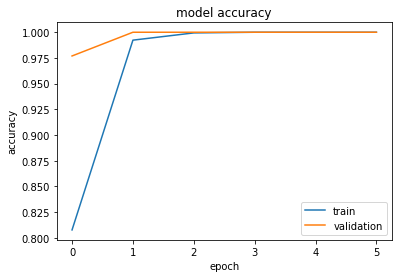

In [6]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [7]:
model = create_cnn_lstm_model(max_words)
history = model.fit(X_train, y_train,epochs=4, batch_size=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           2583100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 200)          120800    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 128)          204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 500, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 125, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 125, 128)         

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Uzimamo poslednjih 5 vrsti
hist.tail()

,loss,acc,epoch
0,0.442159,0.747692,0
1,0.016824,0.996923,1
2,0.001526,0.999487,2
3,0.075372,0.999487,3


In [9]:
df1 = pd.read_csv("test.csv")
df1.rename(columns={ '0':'tekst', '1':'pisac'}, 
                 inplace=True)

(X_test, y_test, kolone, word_index) = pretprocesiraj(df1, max_len)
max_words = len(word_index)



Found 19855 unique tokens. 
Data Shape: (199, 500)
(199, 500) int32
(199, 2) uint8


In [10]:
evaluacija_binarna_klasifikacija(X_test, y_test, model, kolone, word_index)

Preciznost: 0.853
Recall skor: 0.646
F1: 0.736


MATRICA KOFUZIJE
[[89 11]
 [35 64]]


 Neki promaseni pasusi: 


iz vecernjih secanja 142 ispustila je carapu protrljala ozeble ruke i naglo ustala od prozora bio je potpun mrak u sobi mora da je dockan sva kruta od studeni tesko se resavala da li da prvo upali svetlost pa da onda podstakne vatru ili obrnuto tako je neodlucna stajala jedno vreme u mraku nasred sobe a onda se resi sa srecnim osmejkom da odlozi oba ta nemila posla bar za koji trenutak i da umesto toga pregleda jos jednom da li su sva vrata zaista zakljucana koracala je malo nesigurno jos uvek zanesena mnogim secanjima koja su veceras na nju navalila kao nikad u potpunoj tami u slatkoj tami koja je isto sto i stednja dakle isto sto i novac izisla je u predsoblje pipajuci naviklim pokretima znane predmete ali pre nego sto je dosla do kucnih vrata naidje u tami ispruzenom rukom na nekog ote joj se kratak i promukao vrisak takav da se i sama uplasi od njega sva pretrnu i nadje

#REFERENCA: https://medium.com/@romannempyre/sentiment-analysis-using-1d-convolutional-neural-networks-part-1-f8b6316489a2